In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [3]:
print(__doc__)

import time
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import signale
import numpy as np
import matplotlib.pyplot as pl
import spectrum as sp
import cPickle as pkl
import scipy.signal as scsig
import pywt
import colormaps as mycmps
import signale.tools as tools
import os
import itertools
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from matplotlib.mlab import  PCA as mlabPCA
from mtspec import mtspec

/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/chenani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Automatically created module for IPython interactive environment


In [4]:
colors = np.array([x for x in 'bgrkcmybgrkcmybgrkcmybgrkcmy'])
colors = np.hstack([colors] * 20)
#colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
#seabC = sns.xkcd_palette(colors)
colorsss = ['#FF0000', '#0000FF', '#008000', '#00FFFF', '#FF00FF', '#EE82EE',
        '#808000', '#800080', '#FF6347', '#FFFF00', '#9ACD32', '#4B0082',
        '#FFFACD', '#C0C0C0', '#A0522D', '#FA8072', '#FFEFD5', '#E6E6FA',
        '#F1FAC1', '#C5C5C5', '#A152ED', '#FADD72', '#F0EFD0', '#EEE6FF',
        '#01FAC1', '#F5F5F5', '#A152FF', '#FAFD72', '#F0EFDF', '#EEEFFF',
        '#F1FA99', '#C9C9C9', '#A152DD', '#FA5572', '#FFFFD0', '#EDD6FF']
def zScore(array):
    return(array - np.average(array))/ np.std(array)
clPalette = sns.color_palette('deep')

In [21]:
animalPath = '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3839/'
dataFolder = '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3839Control/dataFiles/sleepDB/'
freqz = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/files/freqZ.nparr','rb'))
animal = dataFolder.split('/')[-4]

In [22]:
rippDB_orig = pd.read_pickle(dataFolder+'Rat3839-rippDB.db')
rippPSD = pkl.load(open(dataFolder+'Rat3839rippPSD-mtm.npArr','rb'))
whiteRippPSD = pkl.load(open(dataFolder+'Rat3839whiteRippPSD-mtm.npArr','rb'))
rippSignal = pkl.load(open(dataFolder + 'Rat3839rippSignal.npArr','rb'))
rippDB_orig.shape

(15712, 8)

In [23]:
zeros = np.where(rippPSD==0)
for ii,jj in zip(zeros[0],zeros[1]):
    rippPSD[ii,jj] = rippPSD[ii,jj-1]+rippPSD[ii,jj+1]/2
wzeros = np.where(whiteRippPSD==0)
for ii,jj in zip(wzeros[0],wzeros[1]):
    whiteRippPSD[ii,jj] = whiteRippPSD[ii,jj-1]+whiteRippPSD[ii,jj+1]/2
zeros

(array([], dtype=int64), array([], dtype=int64))

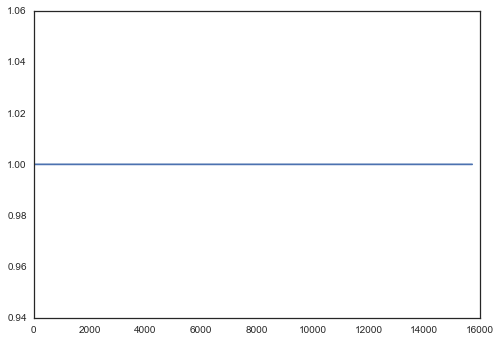

In [24]:
zeroMask = (rippPSD[:,0]>100)
rippDB = rippDB_orig[zeroMask]
rippPSD = rippPSD[zeroMask,:]
whiteRippPSD = whiteRippPSD[zeroMask,:]
pl.plot(zeroMask)
#pkl.dump(rippPSD,open(dataFolder+'Rat614ControlrippPSD-mtm.npArr','wb'))
#pkl.dump(whiteRippPSD,open(dataFolder+'Rat614ControlwhiteRippPSD-mtm.npArr','wb'))

In [30]:
for ii,item in enumerate(sorted(set(rippDB.date))):
    print item
    rippDB = rippDB.replace(item,'day'+str(ii+1))

rippDB = rippDB[rippDB.date=='day1']
rippDB
rippPSD = pkl.load(open(dataFolder+'Rat3839rippPSD-mtm.npArr','rb'))[rippDB.index]
rippPSD.shape,rippDB.index,rippDB.shape
whiteRippPSD = pkl.load(open(dataFolder+'Rat3839whiteRippPSD-mtm.npArr','rb'))[rippDB.index]
#rippSignal = pkl.load(open(dataFolder + 'Rat3839rippSignal.npArr','rb'))
#rippDB_orig.shape

day1
day2
day3
day4
day5
day6


### Zcoring PSD dataframes

In [31]:
for jjj in range(rippPSD.shape[0]):
    rippPSD[jjj,:] = zScore(np.log10(rippPSD[jjj,:]))
    whiteRippPSD[jjj,:] = zScore(np.log10(whiteRippPSD[jjj,:]))

## PCA of PSD dataframes

Calculating PCA components of SWR power spectrum (both white and original) and adding the first 5 PC components to SWR dataframe!

In [32]:
pca = mlabPCA(rippPSD)
wpca = mlabPCA(whiteRippPSD)
usefulComps = pca.Y[:,range(5)]
wusefulComps = wpca.Y[:,range(5)]

In [33]:
rippDB['PC1'] = usefulComps[:,0]
rippDB['PC2'] = usefulComps[:,1]
rippDB['PC3'] = usefulComps[:,2]
rippDB['PC4'] = usefulComps[:,3]
rippDB['PC5'] = usefulComps[:,4]
rippDB['wPC1'] = wusefulComps[:,0]
rippDB['wPC2'] = wusefulComps[:,1]
rippDB['wPC3'] = wusefulComps[:,2]
rippDB['wPC4'] = wusefulComps[:,3]
rippDB['wPC5'] = wusefulComps[:,4]

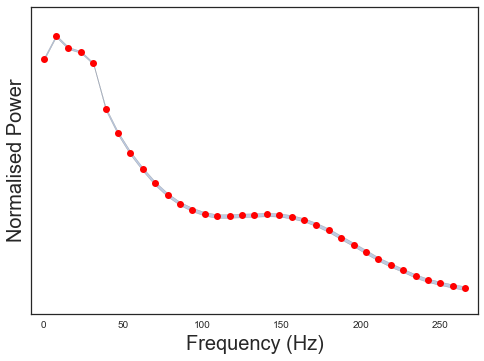

In [35]:
#whiteRippPSD.shape,freqz[:35]
sns.set_style('white')
sns.tsplot(rippPSD,time=freqz[:35],ci=[99.9,99.999],interpolate=False,c='r')
pl.yticks([])
pl.ylabel('Normalised Power',fontsize=20)
pl.xlabel('Frequency (Hz)',fontsize=20)

In [171]:
#rippDB.to_pickle(dataFolder+animal+'-RipplesTimeDB.pd')

## Creating Feature files and Clustering

In [278]:
Rkeys =  rippDB.keys()
keys = Rkeys[[8,9,10,11,12]]
wkeys = Rkeys[[13,14,15,16,17]]
features = rippDB[keys].as_matrix()
wfeatures = rippDB[wkeys].as_matrix()
np.savetxt(dataFolder+'pink.fet.11',features,fmt='%f',delimiter='\t',
           header=str(features.shape[1]),comments='')
np.savetxt(dataFolder+'white.fet.11',wfeatures,fmt='%f',delimiter='\t',
           header=str(wfeatures.shape[1]),comments='')

Clustering is done using KlustaKwik program in unix console
## Loading Clusters

In [37]:
c = np.int16(np.loadtxt(dataFolder+'pink.clu.11'))[1:]
wc = np.int16(np.loadtxt(dataFolder+'white.clu.11'))[1:]
rippDB['wc'] = wc
rippDB['c'] = c

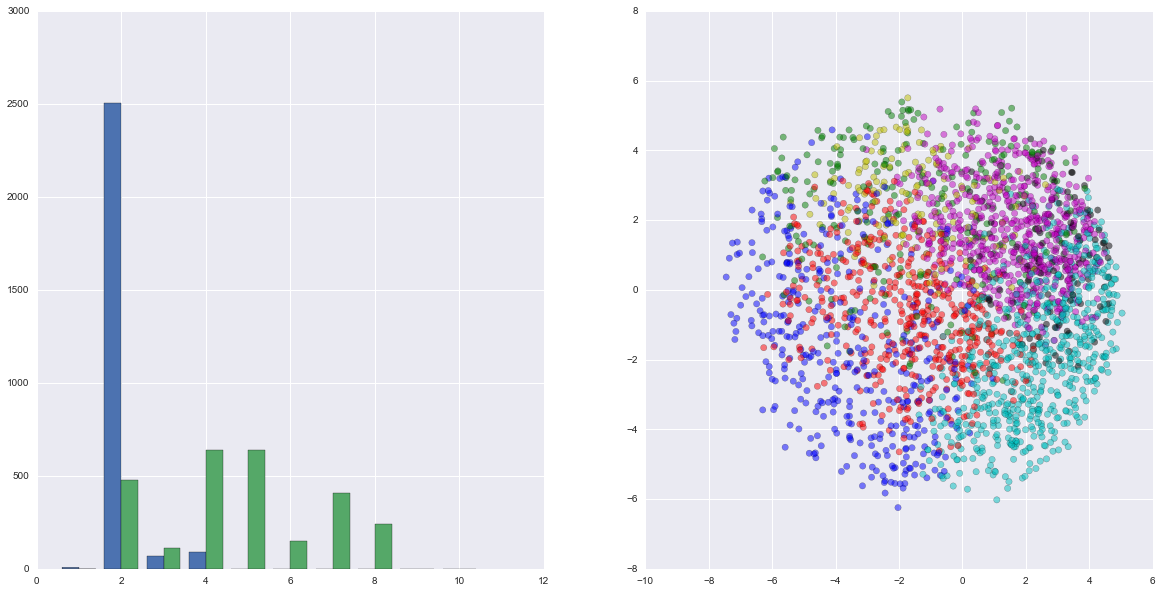

In [57]:
f,(ax,bx) = pl.subplots(1,2,figsize=[20,10])
cCounts = ax.hist([c,wc],bins=np.arange(0.5,11.5,1),label=['pink','white']);
bx.scatter(rippDB.wPC1,rippDB.wPC2,c=colors[wc],alpha=0.5,s=40)

In [18]:
Rcond = np.logical_or(np.logical_or(rippDB.wc ==2, rippDB.wc == 300),rippDB.wc==800)
Gcond = np.logical_or(rippDB.wc ==3, rippDB.wc == 900)


#Rcond = np.logical_or(rippDB.c ==3, rippDB.c == 40)
#Gcond = np.logical_or(rippDB.c ==4, rippDB.c == 50)


/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


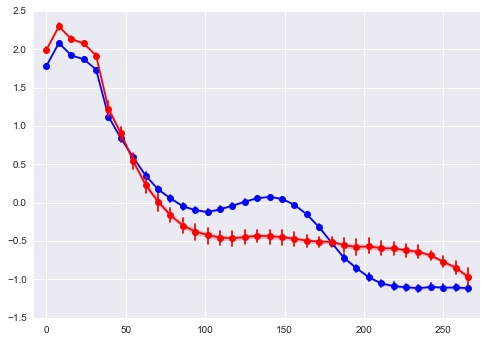

In [19]:
pl.figure()
sns.tsplot(rippPSD[Rcond.as_matrix(),:],time = freqz[:35],color='b')
sns.tsplot(rippPSD[Rcond.as_matrix(),:],time = freqz[:35],color='b',ci=99.9,err_style="ci_bars", interpolate=False)
sns.tsplot(rippPSD[Gcond.as_matrix(),:],time = freqz[:35],color='r')
sns.tsplot(rippPSD[Gcond.as_matrix(),:],time = freqz[:35],color='r',ci=99.9,err_style="ci_bars", interpolate=False)
pl.legend()

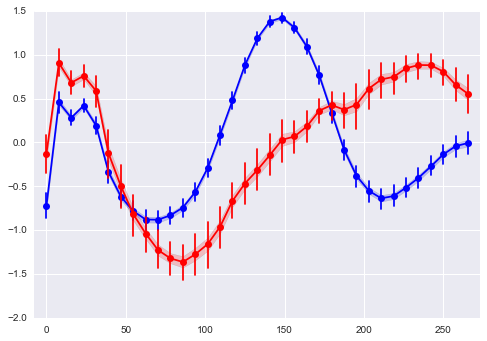

In [20]:
pl.figure()
sns.tsplot(whiteRippPSD[Rcond.as_matrix(),:],time = freqz[:35],color='b')
sns.tsplot(whiteRippPSD[Rcond.as_matrix(),:],time = freqz[:35],color='b',ci=99.9,err_style="ci_bars", interpolate=False)
sns.tsplot(whiteRippPSD[Gcond.as_matrix(),:],time = freqz[:35],color='r')
sns.tsplot(whiteRippPSD[Gcond.as_matrix(),:],time = freqz[:35],color='r',ci=99.9,err_style="ci_bars", interpolate=False)
pl.legend()

In [199]:
np.place(wc,wc==4,[300])
np.place(wc,wc==5,[300])
#np.place(wc,wc==7,[300])
#np.place(wc,wc==8,[300])
#np.place(wc,wc==11,[300])
np.place(wc,wc==2,[100])
np.place(wc,wc==7,[100])
np.place(wc,wc==6,[100])
#np.place(wc,wc==9,[100])
np.place(wc,wc==3,[200])
np.place(wc,wc==8,[200])

rippDB['wc'] = wc
rippDB['c'] = c
rippDB.to_pickle(dataFolder+animal+'-RipplesTimeDB.pd')

In [80]:
wc -=wc
wc[np.logical_and(rippDB.wPC1>0,rippDB.wPC2>2)] = 300
wc[np.logical_and(rippDB.wPC1<0,rippDB.wPC2<0)] = 100
rippDB['wc'] = wc
rippDB['c'] = c
#rippDB[rippDB.wPC1<-6]

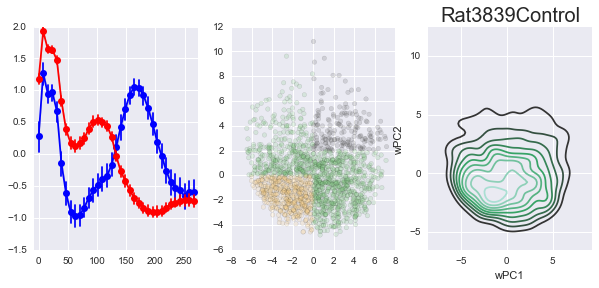

In [81]:
SWRcond = (rippDB.wc ==300)
SGcond = (rippDB.wc ==200)
FGcond = (rippDB.wc ==100)
f,(ax,bx,cx) = pl.subplots(1,3,figsize=[10,4])
sns.tsplot(whiteRippPSD[SWRcond.as_matrix(),:],time = freqz[:35],color='b',ax=ax)
sns.tsplot(whiteRippPSD[SWRcond.as_matrix(),:],time = freqz[:35],color='b',ci=99.9,err_style="ci_bars", interpolate=False,ax=ax)
sns.tsplot(whiteRippPSD[FGcond.as_matrix(),:],time = freqz[:35],color='r',ax=ax)
sns.tsplot(whiteRippPSD[FGcond.as_matrix(),:],time = freqz[:35],color='r',ci=99.9,err_style="ci_bars", interpolate=False,ax=ax)
#sns.tsplot(whiteRippPSD[SGcond.as_matrix(),:],time = freqz[:35],color=seabC[2],ax=ax)
#sns.tsplot(whiteRippPSD[SGcond.as_matrix(),:],time = freqz[:35],color=seabC[2],ci=99.9,err_style="ci_bars", interpolate=False,ax=ax)
bx.scatter(rippDB.wPC1,rippDB.wPC2,c=rippDB.wc,alpha=0.2,cmap='Accent')
sns.kdeplot(rippDB.wPC1,rippDB.wPC2,ax=cx)
pl.title(animal,fontsize=20)
#pl.legend()

In [82]:
1e2*FGcond.sum()/FGcond.size,1e2*SGcond.sum()/SGcond.size,1e2*SWRcond.sum()/SWRcond.size

(27.799886299033542, 0.0, 10.46048891415577)

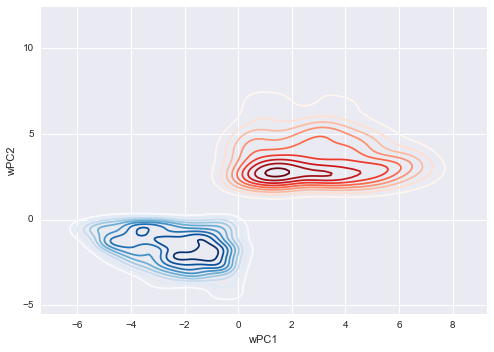

In [83]:
f,ax = pl.subplots(1,1)
sns.kdeplot(rippDB.wPC1[SWRcond],rippDB.wPC2[SWRcond],cmap="Reds", shade=False, shade_lowest=False,ax=ax)
sns.kdeplot(rippDB.wPC1[FGcond],rippDB.wPC2[FGcond],cmap="Blues", shade=False, shade_lowest=False,ax=ax)
#sns.kdeplot(rippDB.wPC1[SGcond],rippDB.wPC2[SGcond],cmap="Greens", shade=False, shade_lowest=False,ax=ax)

In [43]:
colors

['windows blue', 'amber', 'greyish', 'faded green', 'dusty purple']